<a href="https://colab.research.google.com/github/Intelligence-Engineering-LAB-KU/Deeplearning-Tutorial/blob/master/Tutorial_5_text_classification_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

이 튜토리얼은 텐서플로우에서 제작한 [튜토리얼](https://www.tensorflow.org/tutorials/text/text_classification_rnn)을 번역하여 제작되었습니다. 

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## 필요 라이브러리 설치

In [2]:
!pip install -q tfds-nightly

In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf

`matplotlib`를 Import하고 그래프글 그려주는 함수를 만들어보겠습니다.

In [4]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

## 인풋 데이터 받기


IMDB은 대규모의 영화 리뷰 데이터셋입니다. 이 데이터 셋은 이진 분류 (클래스가 두 개인 분류) 데이터 세트입니다. 각 리뷰는 영화에 대한 긍정적 이거나 부정적인 감정 레이블을 가지고 있습니다. [TFDS](https://www.tensorflow.org/datasets)를 사용하여 데이터 세트를 다운로드해 보겠습니다.

In [5]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

데이터 세트 `info` 에는 인코더 (`tfds.deprecated.text.SubwordTextEncoder`)가 포함되어 있습니다.

In [6]:
encoder = info.features['text'].encoder

In [7]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


이 데이터 셋에서 사용되는 토큰의 개수(vocab_size)는 8185개였습니다.


이 텍스트 인코더는 모든 문자열을 가역적으로 인코딩하고 필요한 경우 바이트 인코딩으로 대체합니다.


In [8]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [9]:
assert original_string == sample_string

In [10]:
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


"Hello TensorFlow."라는 문장이 다음과 같은 숫자열로 인코딩되었습니다. 

```
4025, 222, 6307, 2327, 4043, 2120, 7975
```

인코딩 된 결과를 보니, 단어 단위로 인코딩 된 것이 아니라, 그 보다 더 작은 단위 (sub_word)로 인코딩되었습니다. 심심하니까 sub_word에 어떤 것들이 있나 한 번 출력해보겠습니다.

In [11]:
print(encoder.subwords)

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_', 't_', 'with_', 'for_', '.<', 'on_', 'but_', 'movie_', ' (', 'are_', 'his_', 'have_', 'film_', 'not_', 'ing_', 'be_', 'ed_', 'you_', ' "', 'it', 'd_', 'an_', 'he_', 'by_', 'at_', 'one_', 'who_', 'y_', 'from_', 'e_', 'or_', 'all_', 'like_', 'they_', '" ', 'so_', 'just_', 'has_', ') ', 'her_', 'about_', 'out_', 'This_', 'some_', 'ly_', 'movie', 'film', 'very_', 'more_', 'It_', 'would_', 'what_', 'when_', 'which_', 'good_', 'if_', 'up_', 'only_', 'even_', 'their_', 'had_', 'really_', 'my_', 'can_', 'no_', 'were_', 'see_', 'she_', '? ', 'than_', '! ', 'there_', 'get_', 'been_', 'into_', ' - ', 'will_', 'much_', 'story_', 'because_', 'ing', 'time_', 'n_', 'we_', 'ed', 'me_', ': ', 'most_', 'other_', 'don', 'do_', 'm_', 'es_', 'how_', 'also_', 'make_', 'its_', 'could_', 'first_', 'any_', "' ", 'people_', 'great_', 've_', 'ly', 'er_', 'made_', 'r_', 'B

## 학습을 위한 데이터 준비

다음으로 이러한 인코딩 된 문자열의 배치를 만들어 보겠습니다. 
수업에서 다루지 않은 실무적인 이야기가 포함되어 있는데, 최대한 자세하게 설명해보겠습니다.

일반적으로 다른 데이터 셋의 경우 다루는 데이터의 shape이 고정적인 편입니다. 그런데 텍스트 데이터의 경우 다루는 데이터가 가변적입니다. 어떤 사람은 영화 리뷰를 짧게 쓰고, 어떤 사람은 길게 쓰기 마련입니다.

그런데, 별렬로 데이이터를 학습시키기 위해서는 shape이 일치해야합니다. (matrix나 tensor의 shape이 정방형이 아니라면, 컴퓨터가 난감해합니다. 이 부분은 다소 기술적인 부분이라 직관적인 수준에서만 말씀드리고 넘어가겠습니다.)

따라서, 다른 모든 문자열의 길이를 배치에서 가장 긴 문자열의 길이와 같도록 맞추되, 뒷부분을 0으로 채워주겠습니다. 이를 padding이라고 부릅니다. padded_batch 메서드를 사용하여 0으로 padded_batch 를 만들어보겠습니다.


In [12]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [13]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

test_dataset = test_dataset.padded_batch(BATCH_SIZE)

## 모델 생성

`tf.keras.Sequential`을 이용하여 모델을 만들어보겠습니다.
첫 번째 레이어는 토큰의 인덱스를 distributed representation으로 만들어주는 임베딩 레이어로 입니다.

임베딩 레이어는 단어 당 하나의 벡터를 저장합니다. 호출되면 단어 인덱스 시퀀스를 벡터 시퀀스로 변환합니다. 이러한 벡터는 훈련 가능한 파라미터입니다. (충분한 데이터에 대한) 훈련 후 유사한 의미를 가진 단어는 종종 유사한 벡터를 갖습니다. 

그 다음으로 사용되는 RNN (Recurrent Neural Network)은 요소를 반복하여 시퀀스 입력을 처리합니다. RNN은 한 시간 단계의 출력을 입력으로 전달한 다음, 다음 시간 단계로 전달합니다.

`tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))`을 이용하여 Bidirenctional LSTM을 만들어 보겠습니다. hidden state를  64 차원으로 만들어 볼 것입니다.

그 이후 Bidirectional LSTM의 인풋은 Dense Layer로 입력됩니다.

마지막 Dense Layer를 통하여 긍-부정의 1차원 값으로 바꿔줍니다.  

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

모델의 모든 레이어가 단일 입력 만 있고 단일 출력을 생성하기 때문에 여기서 Keras 순차 모델을 선택했습니다. 각 상태를 모두 저장 RNN 레이어를 사용하야 더욱 복잡한 작업을 하고 싶으신 경우,  [Keras RNN 가이드]((https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) 를 확인하세요.

이제, Keras 모델을 컴파일하여 학습 프로세스를 구성해보겠습니다.

Loss Function은 BinaryCrossentropy로, optimizer로는 Adam을 사용하겠습니다.


In [15]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## 모델 학습시키기

In [16]:
history = model.fit(train_dataset, epochs=3,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/3
391/391 [==============================] - 865s 2s/step - loss: 0.6201 - accuracy: 0.6293 - val_loss: 0.4359 - val_accuracy: 0.8135
Epoch 2/3
391/391 [==============================] - 872s 2s/step - loss: 0.3236 - accuracy: 0.8718 - val_loss: 0.3323 - val_accuracy: 0.8693
Epoch 3/3
391/391 [==============================] - 868s 2s/step - loss: 0.2438 - accuracy: 0.9102 - val_loss: 0.3211 - val_accuracy: 0.8786


In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

The above model does not mask the padding applied to the sequences. This can lead to skew if trained on padded sequences and test on un-padded sequences. Ideally you would [use masking](../../guide/keras/masking_and_padding) to avoid this, but as you can see below it only have a small effect on the output.

If the prediction is >= 0.5, it is positive else it is negative.

In [18]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [19]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [20]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[0.6063006]]


In [21]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[0.6453327]]


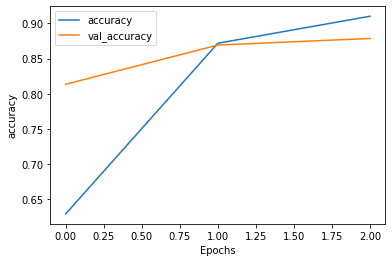

In [22]:
plot_graphs(history, 'accuracy')

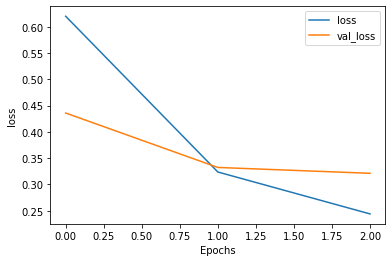

In [23]:
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](../../guide/keras/rnn.ipynb).
